In [1]:
import itertools
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

PROJECT_DIR = os.path.dirname(os.getcwd())
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from chord_recognition.cache import HDF5Cache
from chord_recognition.models import deep_auditory_v2
from chord_recognition.dataset import ChromaDataset, prepare_datasource, undersample_dataset
from chord_recognition.utils import standardize, one_hot
from chord_recognition.train import get_weighted_random_sampler, Solver
from chord_recognition.ann_utils import convert_annotation_matrix, get_chord_labels
from chord_recognition.evaluate import plot_confusion_matrix
from chord_recognition.predict import forward


torch.manual_seed(2020)
RANDOM_STATE = 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

In [2]:
cache = HDF5Cache(os.path.join(PROJECT_DIR, 'chroma_cache.hdf5'))

In [3]:
# Exp5
window_size = 8192
hop_length = 4410

# Balance datasets separately and concat them into single dataset.

# Balance beatles dataset
ds = prepare_datasource(('beatles',))
dataset = ChromaDataset(
    ds, window_size=window_size,
    hop_length=hop_length,
    cache=cache)

sampling_strategy = {
    0: 8000,
    2: 8000,
    4: 8000,
    5: 8000,
    7: 8000,
    9: 8000,
    11: 8000,
    24: 8000,
}
beatles_X, beatles_y = undersample_dataset(
    dataset,
    sampling_strategy,
    RANDOM_STATE)

# Balance robbie_williams dataset
ds = prepare_datasource(('robbie_williams',))
dataset = ChromaDataset(
    ds, window_size=window_size,
    hop_length=hop_length,
    cache=cache)

sampling_strategy = {
    0: 8000,
    2: 8000,
    5: 8000,
    7: 8000,
    9: 8000,
    24: 5000,
}
robbie_williams_X, robbie_williams_y = undersample_dataset(
    dataset,
    sampling_strategy,
    RANDOM_STATE)

# Balance queen dataset
ds = prepare_datasource(('queen',))
dataset = ChromaDataset(
    ds, window_size=window_size,
    hop_length=hop_length,
    cache=cache)

sampling_strategy = {
    2: 4500,
}
queen_X, queen_y = undersample_dataset(
    dataset,
    sampling_strategy,
    RANDOM_STATE)

# Get zweieck data
ds = prepare_datasource(('zweieck',))
dataset = ChromaDataset(
    ds, window_size=window_size,
    hop_length=hop_length,
    cache=cache)

zweieck_X = [xi for xi, _ in dataset]
zweieck_y = [yi for _, yi in dataset]

In [4]:
# Concat all datasets
dataset = itertools.chain(
    zip(beatles_X, beatles_y),
    zip(robbie_williams_X, robbie_williams_y),
    zip(beatles_X, beatles_y),
    zip(queen_X, queen_y),
    zip(zweieck_X, zweieck_y),
)

In [5]:
# Split dataset into train/val keeping equal proportions of the each class
# Now train and val datasets have equal class probability distributions.
ds1, ds2 = itertools.tee(dataset)
X = [s for s, _ in ds1]
targets = [t for _, t in ds2]
indices = np.arange(len(X))
X_train, X_val, y_train, y_val, _, _ = train_test_split(
    X, targets, indices, test_size=0.2, stratify=targets, random_state=RANDOM_STATE)

In [6]:
# Calculate TRAIN_MEAN, TRAIN_STD
X_train_temp = np.hstack([sample.squeeze(0) for sample in X_train])
TRAIN_MEAN = X_train_temp.mean(axis=1).reshape(-1, 1)
TRAIN_STD = X_train_temp.std(axis=1).reshape(-1, 1)

# Rescale inputs to have a mean of 0 and std of 1
train_data = [(standardize(i, TRAIN_MEAN, TRAIN_STD), t) for i, t in zip(X_train, y_train)]
val_data = [(standardize(i, TRAIN_MEAN, TRAIN_STD), t) for i, t in zip(X_val, y_val)]

del X_train_temp, X_train, X_val

In [7]:
# Balance the classes in each batch which hopefully helps the training.
sampler = get_weighted_random_sampler(targets, y_train)

In [8]:
batch_size = 512

# Split dataset into train/val datasets
loader_train = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    sampler=sampler,
    pin_memory=True,
    num_workers=0)
loader_val = DataLoader(
    dataset=val_data,
    num_workers=0,
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

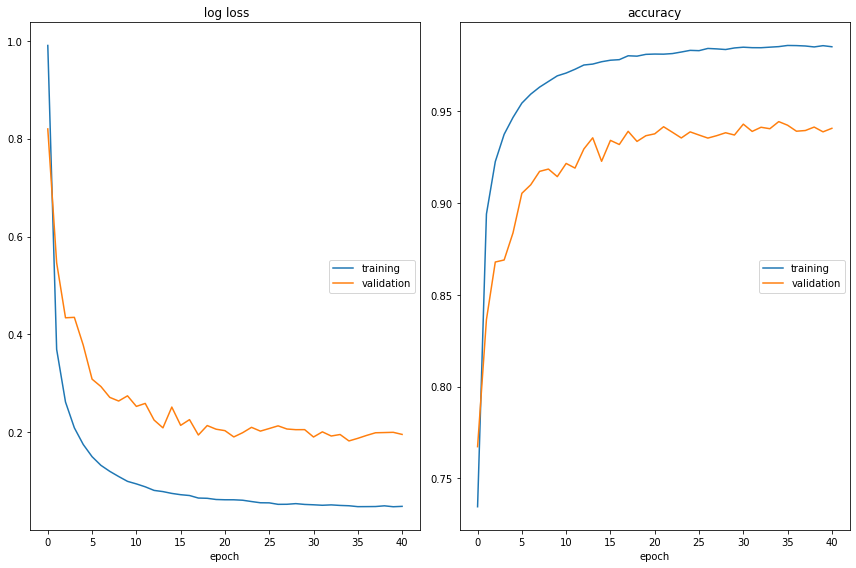

 log loss
	training         	 (min:    0.048, max:    0.990, cur:    0.049)
	validation       	 (min:    0.182, max:    0.820, cur:    0.196)
accuracy
	training         	 (min:    0.735, max:    0.986, cur:    0.985)
	validation       	 (min:    0.767, max:    0.944, cur:    0.941)


KeyboardInterrupt: 

In [17]:
model = deep_auditory_v2()
if torch.cuda.is_available():
    model.cuda()
learning_rate = 1e-3
epochs=50
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay, amsgrad=True)

solver = Solver(
    model=model,
    optimizer=optimizer,
    dataloaders=dataloaders,
    learning_rate=learning_rate,
    trained_model_name="deep_auditory_v2_exp5_1.pth",
    epochs=epochs)
solver.train()

In [9]:
device = torch.device('cpu')

model = deep_auditory_v2(pretrained=True, model_name='deep_auditory_v2_exp5_1.pth')
if torch.cuda.is_available():
    device = torch.device('cuda')
    model.cuda()
model.eval()

DeepAuditoryV2(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3a_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_5a_12x9): FactChroma(
    (branch12x9_1): Ba

In [10]:
val_loader = (i for i,_ in loader_val)
y_hat_matrix = forward(model, val_loader, device, 25)

In [11]:
y_hat_matrix = y_hat_matrix.cpu().data.numpy()

In [12]:
y_pred = np.argmax(y_hat_matrix, 1)
y_pred = one_hot(y_pred, 25)
y_pred = convert_annotation_matrix(y_pred)

[[5296    6   64    0   39   47   13   78    7   18   59   11    9    7
     9    0   17    6    4   15    0   31    0    5   36]
 [   3 3231    0    9    3    0   17    0   24    2    0    9    0    6
     0    3    0    2    8    0   19    0    8    0    2]
 [  77    0 5626    0   80    9   11   53    0  129   14   15    3    1
     5    0    9    0   25    8    1    5    0   14   35]
 [   3    7    8 2879    8    6    3    0   28   11   41    1    3    1
     0    0    0    3    0    4    2    0    2    0    3]
 [   5    2   25    0 4754    1    4   10    5   94    3   46    0   17
     2    0    9    0    3    0    2    9    0   15   21]
 [  80    3   19   20   11 4875    7   39   15   18  104    9    2    0
    30    1   10    5    9   16    0   14    5    2   20]
 [   0    8    0    2    8    0 2219    1    3    1    0   18    0    1
     0    2    0    0    0    0    3    0    0    5   10]
 [ 147    1  196    6   52   66   11 5010    1   85   14   13   18    1
    21    0   28  

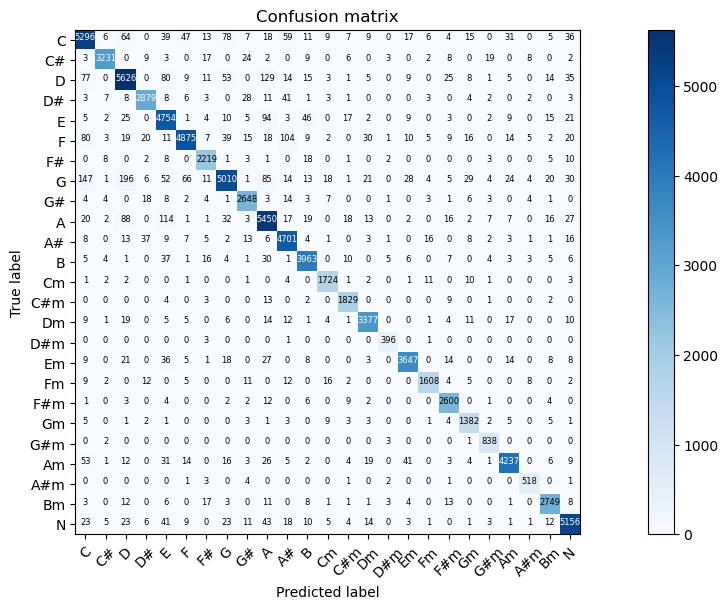

In [13]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

y_matrix = one_hot(y_val, 25)
y_true = convert_annotation_matrix(y_matrix)

labels = get_chord_labels(nonchord=True)
cm = confusion_matrix(y_true, y_pred, labels=labels)
print(cm)

plot_confusion_matrix(cm, labels, fontsize=6)